# Line detection with PCLines

This notebook shows step by step how to use `pclines` package for line detection.

In [59]:
import numpy as np
from skimage.io import imread
from skimage.filters import sobel
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pclines import PCLines
from pclines import utils

%matplotlib inline

## Prapare data

Here we extract edges with a *sobel filter* which may not be suitable for your application. It is just for demonstration purposes. You need to develop your, application specific way. The input to PClines is simply `Nx2` matrix with coordinates enclosed in known bounding box. Any point outside the devined box is ignored.

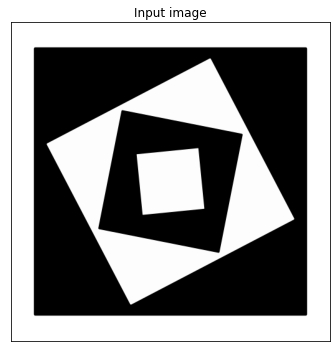

In [70]:
image = imread("doc/test.png", as_gray=True)

_,ax = plt.subplots(1, figsize=(5,5))
ax.imshow(image, cmap="gray")
ax.set(title="Input image", xticks=[], yticks=[])
plt.tight_layout()

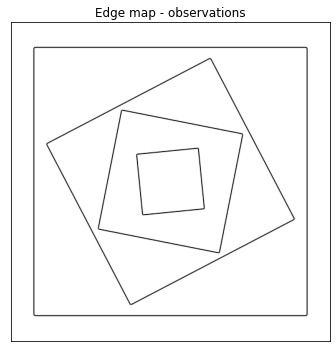

In [71]:
edges = sobel(image)
r,c = np.nonzero(edges > 0.5)  # Locations of edges
x = np.array([c,r],"i").T  # Matrix with edges [(x1,y1), ... ]
weights = edges[r,c]
weights.shape

_,ax = plt.subplots(1, figsize=(5,5))
ax.imshow(edges, cmap="Greys")
ax.set(title="Edge map - observations", xticks=[], yticks=[])
plt.tight_layout()

## Accumulate the observations

An instance of `PCLines` must be created and observations - 2D point coordinates are inserted using `insert` method. This can be called multiple times to fill the accumulator space. The peaks are located using `find_peaks` - each peak corresponds to a line in the original space.

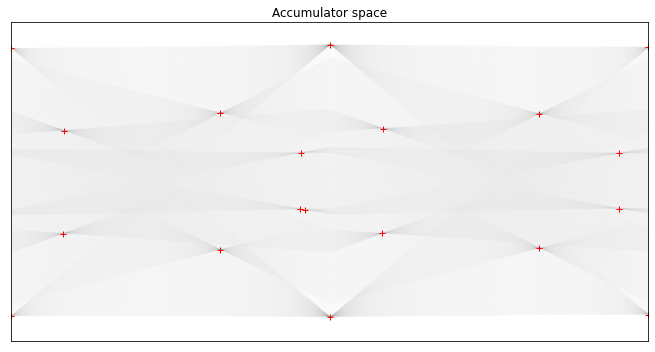

In [72]:
h,w = image.shape[:2]
bbox=(0,0,w,h)
d = 1024

# Create new accumulator
P = PCLines(bbox, d)

# Insert observations
P.insert(x, weights)

# Find local maxima
p, w = P.find_peaks(min_dist=10, prominence=1.3, t=0.1)

f,ax = plt.subplots(1, figsize=(10,5))
ax.plot(p[:,1], p[:,0], "r+")    
ax.imshow(np.sqrt(P.A), cmap="Greys")
ax.set(title="Accumulator space",xticks=[],yticks=[])
plt.tight_layout()

## Obtain line parameters from the accumulator

Local maxima form `find_peaks` can be transformed usin `inverse` to line parameters in $(a,b,c)$ form - line $ax + by + c = 0$

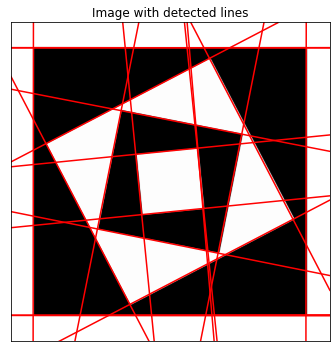

In [73]:
h = P.inverse(p)

X,Y = utils.line_segments_from_homogeneous(h, bbox)
f,ax = plt.subplots(figsize=(5,5))
ax.imshow(image, cmap="gray")
for x,y in zip(X,Y):
    if x is None or y is None:
        continue
    l = Line2D(x,y, color="r")
    ax.add_artist(l)
ax.set(title="Image with detected lines", xticks=[], yticks=[])
plt.tight_layout()